In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df_test = pd.read_csv("test-full.csv")
df_train = pd.read_csv("train.csv")
# pour avoir cover type au début
df_train = df_train[[df_train.columns[-1]] + list(df_train.columns[0:-1])]

In [3]:
df_train.shape, df_test.shape

((15120, 56), (581012, 55))

In [4]:
df_test.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,0
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,0
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,0
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,0
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df_train["Cover_Type"].value_counts()

1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
Name: Cover_Type, dtype: int64

### Basis script

In [6]:
from sklearn.ensemble import RandomForestClassifier

# Separate features and target 
X_train = df_train.drop('Cover_Type', axis=1)
y_train = df_train['Cover_Type']

# Initialize and train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Creating a Test dataset
X_test = df_test

# Make predictions on the test dataset
y_pred = clf.predict(X_test)

# Saving predictions to a CSV file
predictions_df = pd.DataFrame({'Cover_Type': y_pred})

# Having it fit the desired format
Id = [i for i in range (1, 581013)]
predictions_df['Id'] = Id
# predictions_df.to_csv('test_predictions.csv', index=False) # peut-être plus simple de directement mettre index = True


In [7]:
predictions_df["Cover_Type"].value_counts()

2    236112
1    216326
3     38178
7     31667
5     28425
6     26278
4      4026
Name: Cover_Type, dtype: int64

### First train-test

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Si on met que la df en input
def RF_classif(df_train=df_train):
    
    if "Wilderness_Area_Synth" in df_train.columns:
        df_train = df_train.drop(columns="Wilderness_Area_Synth")

    # Separate features and target 
    X_train = df_train.drop('Cover_Type', axis=1)
    y_train = df_train['Cover_Type']

    data_train, data_test, target_train, target_test = train_test_split(
        X_train, y_train, test_size = 0.2
    )

    # Initialize and train a Random Forest classifier
    clf = RandomForestClassifier(n_estimators=150)
    clf.fit(data_train, target_train)

    # Make predictions on the test dataset
    y_pred = clf.predict(data_test)
    
    return target_test, y_pred

# Si test & train déjà définis
def RF_classif_train_test(data_train, target_train, data_test, target_test):

    # Initialize and train a Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(data_train, target_train)

    # Make predictions on the test dataset
    y_pred = clf.predict(data_test)
    
    return target_test, y_pred

In [9]:
y_true, y_pred = RF_classif()
accuracy_score(y_true, y_pred) # bien meilleur score que sur Kags

0.8799603174603174

In [11]:
print(classification_report(y_true, y_pred))

# On prédit moins bien 1 et 2, ce qui est un problème pcq représentent une immense majorité du dataset final

              precision    recall  f1-score   support

           1       0.82      0.78      0.80       468
           2       0.79      0.70      0.75       429
           3       0.88      0.86      0.87       425
           4       0.95      0.99      0.97       402
           5       0.92      0.96      0.94       446
           6       0.86      0.90      0.88       429
           7       0.92      0.98      0.95       425

    accuracy                           0.88      3024
   macro avg       0.88      0.88      0.88      3024
weighted avg       0.88      0.88      0.88      3024



# Over/undersampling

In [13]:
# on peut essayer d'undersampler wilderness area 4 
# pcq à ce stade il semblerait que a été tiré uniformément dans les wilderness areas

# ou alors oversampler tous les autres pour aboutir à des proportions similaires à celles d'origine

# Ou alors oversampler directement des classes (ex 1 et 2 mais peut être problématique)

### Undersampling WA4

In [14]:
# How much class 4 do we want
0.08 * len(df_train) * 0.8

967.6800000000002

In [15]:
### UNDERSAMPLING W4

from imblearn.under_sampling import RandomUnderSampler

# Separating train and test
X = df_train.drop('Cover_Type', axis=1)
y = df_train['Cover_Type']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)

# Reuniting data_train and target_train
data_train = pd.concat([X_train, pd.DataFrame(y_train, columns=['Cover_Type'])], axis=1)

# Define the under-sampler
under_sampler = RandomUnderSampler(sampling_strategy={4: 1000})

# Undersampling on the wilderness area
X_try = data_train.drop('Wilderness_Area_Synth', axis=1)
y_try = data_train["Wilderness_Area_Synth"]
X_resampled, _ = under_sampler.fit_resample(X_try, y_try)
X_resampled = pd.DataFrame(X_resampled, columns=X_try.columns)

# Finalizing on the columns 
X_train_synth = X_resampled.drop('Cover_Type', axis=1)
y_train_synth = X_resampled["Cover_Type"]
X_test = X_test.drop('Wilderness_Area_Synth', axis=1)

KeyError: "['Wilderness_Area_Synth'] not found in axis"

In [ ]:
X_train_synth[wilderness_types].sum()

Wilderness_Area1    2847
Wilderness_Area2     445
Wilderness_Area3    5058
Wilderness_Area4    1000
dtype: int64

In [ ]:
y_true, y_pred = RF_classif_train_test(X_train_synth, y_train_synth, X_test, y_test)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.80      0.81      0.81       435
           2       0.84      0.72      0.78       429
           3       0.83      0.80      0.82       427
           4       0.90      0.97      0.94       430
           5       0.91      0.94      0.93       406
           6       0.83      0.85      0.84       436
           7       0.93      0.97      0.95       461

    accuracy                           0.87      3024
   macro avg       0.87      0.87      0.87      3024
weighted avg       0.87      0.87      0.87      3024



In [ ]:
### => Ne semble pas très concluant à priori mais à tester sur le Kaggle

### Oversampling WA1 

In [ ]:
data_train["Wilderness_Area_Synth"].value_counts()

3    5058
4    3746
1    2847
2     445
Name: Wilderness_Area_Synth, dtype: int64

In [ ]:
WA_proportions = {1: 0.45,
               2: 0.05,
               3: 0.44,
               4: 0.06}

ovs_strat = {1: 20_000, 3:20_000}

In [ ]:
### OVERSAMPLING W1

from imblearn.over_sampling import ADASYN

# Separating train and test
X = df_train.drop('Cover_Type', axis=1)
y = df_train['Cover_Type']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)

# Reuniting data_train and target_train
data_train = pd.concat([X_train, pd.DataFrame(y_train, columns=['Cover_Type'])], axis=1)

# Define the under-sampler
adasyn = ADASYN(sampling_strategy=ovs_strat)

# Undersampling on the wilderness area
X_try = data_train.drop('Wilderness_Area_Synth', axis=1)
y_try = data_train["Wilderness_Area_Synth"]
X_resampled, _ = adasyn.fit_resample(X_try, y_try)
X_resampled = pd.DataFrame(X_resampled, columns=X_try.columns)

# Finalizing on the columns 
X_train_synth = X_resampled.drop('Cover_Type', axis=1)
y_train_synth = X_resampled["Cover_Type"]
X_test = X_test.drop('Wilderness_Area_Synth', axis=1)

In [ ]:
y_train_synth.value_counts()

1    15629
2     7740
5     5701
7     4365
3     3820
4     3580
6     3319
Name: Cover_Type, dtype: int64

In [ ]:
y_true, y_pred = RF_classif_train_test(X_train_synth, y_train_synth, X_test, y_test)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.77      0.82      0.80       408
           2       0.81      0.66      0.73       429
           3       0.88      0.86      0.87       461
           4       0.93      0.98      0.95       431
           5       0.90      0.95      0.93       422
           6       0.87      0.88      0.88       441
           7       0.96      0.97      0.96       432

    accuracy                           0.88      3024
   macro avg       0.87      0.88      0.87      3024
weighted avg       0.87      0.88      0.87      3024



In [ ]:
### Pas très net non plus mais on voit qu'on prédit mieux C1 quand même...

### Combining under and oversampler

In [ ]:
ovs_strat = {1: 20_000, 3:20_000}
uds_strat = {4: 1000}

In [ ]:
from imblearn.pipeline import Pipeline

# Separating train and test
X = df_train.drop('Cover_Type', axis=1)
y = df_train['Cover_Type']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)

# Reuniting data_train and target_train
data_train = pd.concat([X_train, pd.DataFrame(y_train, columns=['Cover_Type'])], axis=1)

# Define the under-over-sampler
pipeline = Pipeline([
    ('under', RandomUnderSampler(sampling_strategy=uds_strat)), 
    ('over', ADASYN(sampling_strategy=ovs_strat))  
])

# Undersampling on the wilderness area
X_try = data_train.drop('Wilderness_Area_Synth', axis=1)
y_try = data_train["Wilderness_Area_Synth"]
X_resampled, _ = pipeline.fit_resample(X_try, y_try)
X_resampled = pd.DataFrame(X_resampled, columns=X_try.columns)

# Finalizing on the columns 
X_train_synth = X_resampled.drop('Cover_Type', axis=1)
y_train_synth = X_resampled["Cover_Type"]
X_test = X_test.drop('Wilderness_Area_Synth', axis=1)

In [ ]:
X_train_synth[wilderness_types].sum()

Wilderness_Area1    19974
Wilderness_Area2      467
Wilderness_Area3    20131
Wilderness_Area4     1000
dtype: int64

In [ ]:
y_train_synth.value_counts()

1    15386
2     7974
5     5565
7     4732
3     2967
6     2611
4     2337
Name: Cover_Type, dtype: int64

In [ ]:
### Pb on n'arrive pas aux proportions prédites dans le dataset test
# alors essayer de travailler directement sur Cover_Type plutôt que WA?

### Working directly on the Cover Type

In [ ]:
predictions_df["Cover_Type"].value_counts() / len(predictions_df)

2    0.406381
1    0.372326
3    0.065709
7    0.054503
5    0.048923
6    0.045228
4    0.006929
Name: Cover_Type, dtype: float64

In [ ]:
df_train["Cover_Type"].value_counts() / len(df_train)

1    0.142857
2    0.142857
3    0.142857
4    0.142857
5    0.142857
6    0.142857
7    0.142857
Name: Cover_Type, dtype: float64

In [ ]:
### OVERSAMPLING CLASS 2 AND 1

ovs_strat = {1: 15_000, 2: 15_000}

# Separating train and test
X = df_train.drop('Cover_Type', axis=1)
y = df_train['Cover_Type']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)

# Define the over-sampler
adasyn = ADASYN(sampling_strategy=ovs_strat)

# Oversampling
X_train_synth, y_train_synth = adasyn.fit_resample(X_train, y_train)
X_train_synth = pd.DataFrame(X_train_synth, columns=X_train.columns)

In [ ]:
y_train_synth.value_counts() / len(y_train_synth)

1    0.390051
2    0.386478
7    0.045005
6    0.044979
3    0.044720
4    0.044642
5    0.044125
Name: Cover_Type, dtype: float64

In [ ]:
X_train_synth["Wilderness_Area_Synth"].value_counts() / len(X_train_synth)

3    0.417784
1    0.358512
2    0.124735
4    0.098969
Name: Wilderness_Area_Synth, dtype: float64

In [ ]:
y_true, y_pred = RF_classif_train_test(X_train_synth, y_train_synth, X_test, y_test)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.78      0.82      0.80       440
           2       0.72      0.77      0.74       414
           3       0.87      0.85      0.86       433
           4       0.94      0.98      0.96       436
           5       0.93      0.86      0.90       456
           6       0.88      0.85      0.86       423
           7       0.96      0.93      0.94       422

    accuracy                           0.87      3024
   macro avg       0.87      0.87      0.87      3024
weighted avg       0.87      0.87      0.87      3024



In [ ]:
# Par rapport à avant, améliore le recall (moins de faux négatifs) mais diminue la précision (plus de faux positifs)

y_true, y_pred = RF_classif(df_train)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.82      0.79      0.80       455
           2       0.82      0.74      0.78       455
           3       0.89      0.87      0.88       445
           4       0.94      0.98      0.96       427
           5       0.90      0.95      0.93       409
           6       0.87      0.88      0.87       402
           7       0.94      0.98      0.96       431

    accuracy                           0.88      3024
   macro avg       0.88      0.89      0.88      3024
weighted avg       0.88      0.88      0.88      3024



### Trying

In [ ]:
### TEST
from utils import clean_predictor

# Initialize and train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=150)
clf.fit(X_train_synth.drop(columns="Wilderness_Area_Synth"), y_train_synth)

# Make predictions on the test dataset
y_pred = clf.predict(df_test)

# Saving predictions to a CSV file
predictions_df = clean_predictor(y_pred)

# Having it fit the desired format
predictions_df.to_csv('test_predictions.csv', index=False) # peut-être plus simple de directement mettre index = True

In [ ]:
## on atteint 0.82 => Amélioration légère

# Essayer de le faire de manière plus méthodique, en augmentant encore plus et notamment le WA1,
# et en tunant : on dirait que en fonction du fit du ADASYN on a des résultats assez différents

In [ ]:
predictions_df["Cover_Type"].value_counts()

2    252247
1    218870
3     35834
7     27168
6     23240
5     19491
4      4162
Name: Cover_Type, dtype: int64

In [ ]:
# On remarque que on a sensiblement plus de classe 2 prédite ici que à la base

In [ ]:
y_pred = clf.predict(data_train.drop(columns=["Wilderness_Area_Synth", "Cover_Type"]))
accuracy_score(y_pred, data_train["Cover_Type"])
#### On voit que => créé fonction clean_predictor à invoquer quand on prédit

0.9761078042328042

## kmeans + oversampling

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline


### 1. OVERSAMPLING CLASS 2 AND 1
ovs_strat = {1: 30_000, 2: 30_000}

# Separating train 
X_train = df_train.drop(columns=['Cover_Type', 'Wilderness_Area_Synth'], axis=1)
y_train = df_train['Cover_Type']

# Oversampling
adasyn = ADASYN(sampling_strategy=ovs_strat)
X_train_synth, y_train_synth = adasyn.fit_resample(X_train, y_train)
X_train_synth = pd.DataFrame(X_train_synth, columns=X_train.columns)

### 2. KMEANS
df_train_ns = df_train.iloc[:,:16]
df_test_ns = df_test.iloc[:,:15]

km_test = KMeans(n_clusters=3, n_init=10, init="k-means++")
km_test.fit_predict(df_test_ns)
df_test["kmean_cluster"] = km_test.labels_
X_train_synth["kmean_cluster"] = km_test.predict(X_train_synth.iloc[:,:15])

### 3. GENERATING
cat_col = ["kmean_cluster"]
cols = X_train_synth.drop(columns=['kmean_cluster']).columns

preprocessor = ColumnTransformer([
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_col),
        ("others", "passthrough", cols),
    ])
clf = RandomForestClassifier(n_estimators=150)
pipe = make_pipeline(preprocessor, clf)

pipe.fit(X_train_synth, y_train_synth)
y_pred = pipe.predict(df_test)
predictions_df = clean_predictor(y_pred)

# Having it fit the desired format
# predictions_df.to_csv('test_predictions.csv', index=False) 

# Building a solid cross validation metric

Idée : appliquer la "importance weighted cross validation" du paper.

$$\hat{R}^{(n)}_{kIWCV} = \frac{1}{k}\sum_{j=1}^{k} \frac{1}{|T_j|} \sum_{(x_i, y_i) \in T_j} \frac{p_{test}(x_i)}{p_{train}(x_i)} \ell(x_i, y_i, \hat{y_i})$$

Question : comment estimer $\frac{p_{test}(x_i)}{p_{train}(x_i)}$ pour tout $x_i$ du train set?


Question : est-ce que a samplé de manière uniforme sur les classes ? Si oui, on peut juste reweighter sur les proportions des classes. Comment on peut savoir ? On peut nous aussi ressampler au hasard pour avoir des classes uniformes et voir si semble correspondre. 

Note ici notre loss est la l1 loss = 1 - accuracy donc on peut échanger la loss avec l'accuracy

In [ ]:
### Trying to get the same data the train from the test
class_size = 2160
df_copy = pd.DataFrame()

for label in range(1,8):
    class_data = df_train[df_train['Cover_Type'] == label]
    sampled_data = class_data.sample(n=class_size, replace=False, random_state=1000)
    df_copy = pd.concat([df_copy, sampled_data])

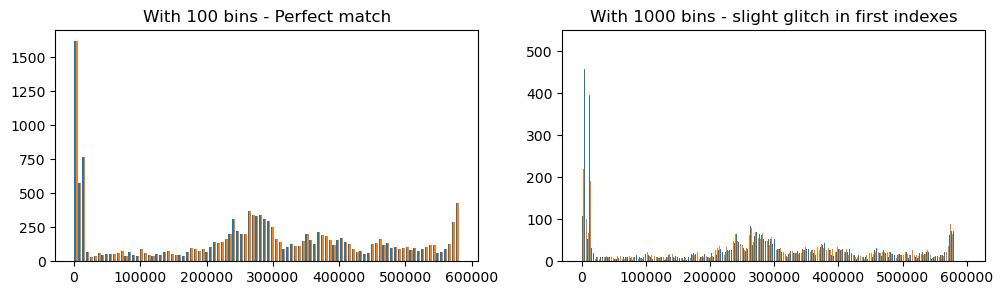

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].hist([df_train["Id"], df_copy["Id"]], bins=100)
axs[0].set_title(f'With 100 bins - Perfect match')
axs[1].hist([df_train["Id"], df_copy["Id"]], bins=range(0, 600_000, 1000))
axs[1].set_title(f'With 1000 bins - slight glitch in first indexes')
plt.show()

Correspond globalement.

On peut donc faire $\frac{p_{test}(x_i)}{p_{train}(x_i)} = \frac{p_{train}(y_i|x_i) p_{test}(y_i) p_{test}(x_i|y_i)}{p_{test}(y_i|x_i) p_{train}(y_i) p_{train}(x_i|y_i)}$

Puis on annule $\frac{p_{train}(y_i|x_i)}{p_{test}(y_i|x_i)}$ par assumption (label shift) et $\frac{p_{train}(x_i|y_i)}{p_{test}(x_i|y_i)}$ par ce qu'on vient de voir (au sein d'une classe donnée, les X ont la même distribution)

Il reste $\frac{p_{test}(x_i)}{p_{train}(x_i)} = \frac{p_{test}(y_i)}{p_{train}(y_i)}$, que l'on peut estimer directement avec les proportions de chaque classe dans le train et indirectement avec les proportions prédites dans le train (c'est une approximation mais ça fera l'affaire

In [ ]:
coeffs = (predictions_df["Cover_Type"].value_counts() / len(predictions_df) / df_train["Cover_Type"].value_counts() * len(df_train)).round(2)
coeffs = np.array([2.63, 3.06, 0.43, 0.05, 0.24, 0.27, 0.32])

1    2.63
2    3.07
3    0.43
4    0.05
5    0.23
6    0.27
7    0.32
Name: Cover_Type, dtype: float64

In [ ]:
def IWCV(df_train=df_train, 
         predictor=RandomForestClassifier(n_estimators=100, random_state=42), 
         k_valid=10,
         coeffs=coeffs):
    
    if "Wilderness_Area_Synth" in df_train.columns:
        df_train = df_train.drop(columns="Wilderness_Area_Synth")
        
    # Separate features and target 
    X_train = df_train.drop('Cover_Type', axis=1)
    y_train = df_train['Cover_Type']
    
    class_accuracies = np.zeros((k_valid, 7))
    
    for i in range(k_valid):
        data_train, data_test, target_train, target_test = train_test_split(
            X_train, y_train, test_size = 1 / k_valid
        )
        predictor.fit(data_train, target_train)
        y_pred = predictor.predict(data_test)

        for label in range(1,8):
            class_accuracies[i, label - 1] = accuracy_score(target_test[target_test == label], 
                                                        y_pred[target_test == label])
        IMCV = np.mean(class_accuracies @ coeffs) / np.sum(coeffs)
        
    return IMCV, class_accuracies.mean(axis=0)

In [ ]:
IWCV()

(0.7884315553654063,
 array([0.7925238 , 0.72946005, 0.87317695, 0.98105265, 0.95399631,
        0.89033947, 0.97159815]))

### Combining IWCV and oversampler

In [ ]:
def IWCV_oversample(df_train=df_train, 
         predictor=RandomForestClassifier(n_estimators=100, random_state=42), 
         k_valid=10,
         coeffs=coeffs) :
    
    ovs_strat = {1: 30_000, 2: 30_000}
    if "Wilderness_Area_Synth" in df_train.columns:
        df_train = df_train.drop(columns="Wilderness_Area_Synth")

    # Define the oversampler
    adasyn = ADASYN(sampling_strategy=ovs_strat) ## Random state = 4 ou 1 sont les meilleurs so far à 0.8297 en CV (mais fixer seed aussi en cross_val...)

    # Separate features and target 
    X_train = df_train.drop('Cover_Type', axis=1)
    y_train = df_train['Cover_Type']
    
    class_accuracies = np.zeros((k_valid, 7))
    
    for i in range(k_valid):
        data_train, data_test, target_train, target_test = train_test_split(
            X_train, y_train, test_size = 1 / k_valid
        )
        
        # Oversampling
        X_train_synth, y_train_synth = adasyn.fit_resample(data_train, target_train)
        X_train_synth = pd.DataFrame(X_train_synth, columns=X_train.columns)
        
        predictor.fit(X_train_synth, y_train_synth)
        y_pred = predictor.predict(data_test)

        for label in range(1,8):
            class_accuracies[i, label - 1] = accuracy_score(target_test[target_test == label], 
                                                        y_pred[target_test == label])
        IMCV = np.mean(class_accuracies @ coeffs) / np.sum(coeffs)
        
    return IMCV, class_accuracies.mean(axis=0)

In [ ]:
# Avec oversampling

# IWCV_oversample() ### don't run takes long

(0.8295062067432254,
 array([0.84199549, 0.79138375, 0.8683433 , 0.98023105, 0.89201993,
        0.86976146, 0.93796203]))

### Oversampling + kmeans

In [ ]:
### Setting pipe
from sklearn.preprocessing import FunctionTransformer

def pipe_setter(n_clusters=3, clf=RandomForestClassifier(n_estimators=100, random_state=42)):
    # Initializing kmeans
    km_test = KMeans(n_clusters=n_clusters, n_init=10, init="k-means++")
    km_test.fit_predict(df_test.loc[:, "Id":"Wilderness_Area4"])

    # Setting pipe
    def _enocode_kmeans(X, kmeans=km_test):
        X = X.copy()
        X["kmean_cluster"] = kmeans.predict(X)
        return X
    km_encoder = FunctionTransformer(_enocode_kmeans)

    cat_col = ["kmean_cluster"]
    cols = df_train.drop(columns=['Cover_Type', 'Wilderness_Area_Synth']).columns

    preprocessor = ColumnTransformer([
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_col),
            ("others", "passthrough", cols),
        ])
    
    return make_pipeline(km_encoder, preprocessor, clf)

In [ ]:
def IWCV_ovs_km(df_train=df_train, 
         predictor=pipe, 
         k_valid=10,
         coeffs=coeffs,
         ovs_strat={1: 30_000, 2: 30_000}):
    
    if "Wilderness_Area_Synth" in df_train.columns:
        df_train = df_train.drop(columns="Wilderness_Area_Synth")

    # Define the oversampler
    adasyn = ADASYN(sampling_strategy=ovs_strat) 

    # Separate features and target 
    X_train = df_train.drop('Cover_Type', axis=1)
    y_train = df_train['Cover_Type']
    
    class_accuracies = np.zeros((k_valid, 7))
    
    for i in range(k_valid):
        data_train, data_test, target_train, target_test = train_test_split(
            X_train, y_train, test_size = 1 / k_valid
        )
        
        # Oversampling
        X_train_synth, y_train_synth = adasyn.fit_resample(data_train, target_train)
        X_train_synth = pd.DataFrame(X_train_synth, columns=X_train.columns)
        
        predictor.fit(X_train_synth, y_train_synth)
        y_pred = predictor.predict(data_test)

        for label in range(1,8):
            class_accuracies[i, label - 1] = accuracy_score(target_test[target_test == label], 
                                                        y_pred[target_test == label])
        IMCV = np.mean(class_accuracies @ coeffs) / np.sum(coeffs)
        
    return IMCV, class_accuracies.mean(axis=0)

In [ ]:
### très bizarre parce que varie énormément => excellents résultats ou bofs alors que mêmes paramètres
# Faire un truc long en 20 - cross val et 3 fois par clusters sur des clusters allant de 3 à 7
### So far on dirait que n_clusters = 7 donne le meilleur résultat mais tuner à la fin

In [ ]:
# dico_km =  
# 3 (0.8345399423561863, array([0.84882253, 0.79977842, 0.85926981, 0.9786671 , 0.88242925,
#        0.86635208, 0.9336357 ]))
# 4 (0.8382094548710572, array([0.85103149, 0.8038529 , 0.87349019, 0.97339922, 0.88498326,
#        0.86922649, 0.93411541]))
# 5 (0.8259548777699849, array([0.83459958, 0.79100115, 0.86031783, 0.98022758, 0.87694589,
#        0.87492816, 0.94199221]))
# 6 (0.8256605234316455, array([0.83774458, 0.7857139 , 0.87296434, 0.97455323, 0.89697963,
#        0.85820505, 0.94403361]))
# 7 (0.8406299332597281, array([0.85340261, 0.8082526 , 0.8536078 , 0.97417891, 0.88834775,
#        0.87670995, 0.94322887]))
# 8 (0.8343907127838309, array([0.8422739 , 0.80129691, 0.867198  , 0.98046184, 0.89575921,
#        0.86753523, 0.9481118 ]))

3 (0.8345399423561863, array([0.84882253, 0.79977842, 0.85926981, 0.9786671 , 0.88242925,
       0.86635208, 0.9336357 ]))
4 (0.8382094548710572, array([0.85103149, 0.8038529 , 0.87349019, 0.97339922, 0.88498326,
       0.86922649, 0.93411541]))
5 (0.8259548777699849, array([0.83459958, 0.79100115, 0.86031783, 0.98022758, 0.87694589,
       0.87492816, 0.94199221]))
6 (0.8256605234316455, array([0.83774458, 0.7857139 , 0.87296434, 0.97455323, 0.89697963,
       0.85820505, 0.94403361]))
7 (0.8406299332597281, array([0.85340261, 0.8082526 , 0.8536078 , 0.97417891, 0.88834775,
       0.87670995, 0.94322887]))
8 (0.8343907127838309, array([0.8422739 , 0.80129691, 0.867198  , 0.98046184, 0.89575921,
       0.86753523, 0.9481118 ]))


# Stacking

In [ ]:
from sklearn.calibration import LabelEncoder
from xgboost import XGBClassifier

data_train, data_test, target_train, target_test = train_test_split(
    X_train, y_train, test_size = 0.2
)

le = LabelEncoder()
target_train = le.fit_transform(target_train)
model = XGBClassifier()
model.fit(data_train, target_train)
y_pred = model.predict(data_test)
y_pred = le.inverse_transform(y_pred)

In [ ]:
print(classification_report(target_test, y_pred)) # Globalement pareil que le RF

              precision    recall  f1-score   support

           0       0.79      0.80      0.79       427
           1       0.79      0.71      0.75       431
           2       0.89      0.88      0.89       433
           3       0.96      0.96      0.96       429
           4       0.90      0.94      0.92       424
           5       0.89      0.91      0.90       430
           6       0.94      0.97      0.96       450

    accuracy                           0.88      3024
   macro avg       0.88      0.88      0.88      3024
weighted avg       0.88      0.88      0.88      3024



In [ ]:
from sklearn.ensemble import StackingClassifier

stacking_clf = {
    estimators = [
        
    ]
}